In [1]:
import copy
import pickle

import ajf_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ajf_bridge_fem import *
from pandarallel import pandarallel
from scipy import stats

import ajf_plts

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Load temperature data

In [2]:
keep_cols = ["air_temperature", "year", "seq_month", "day", "hour"]
temp_data = pd.read_parquet("temp-freq-e_val.parquet").loc[:, keep_cols]

# Load result data 

In [3]:
DAM_LOCS = ["L", "R"]
RUN_ID = "2023-01-29T12:51:27.214729_LB_0.02-step-delta"

MODEL = "GH"
RUN_ID = "2023-02-05T19:45:04.032244_GH_0.05-step-delta"
DAM_LOCS = ["L_pier", "R_pier"]

all_data = (
    pd.read_parquet(f"./{RUN_ID}_w_error")
    .sort_values(["year", "delta"])
    .reset_index(drop=True)
)

all_data.head()

,seq_month,year,month,day,hour,minute,dayofweek,air_temperature,freq,E_val,...,S3,S4,S5,speed,x_dam,delta,L_abut,L_pier,R_pier,R_abut
0,0,0,0,1,1,36,6,4.880000,5.786878,2.883737e+10,...,10.85,NaN,NaN,23.0,17.733333,0.0,0.000138,0.000066,0.000062,0.000135
1,0,0,0,1,4,43,6,3.555000,5.795990,2.892656e+10,...,NaN,NaN,NaN,24.0,17.733333,0.0,0.000257,0.000126,0.000117,0.000246
2,0,0,0,1,5,10,6,3.216667,5.799653,2.896242e+10,...,NaN,NaN,NaN,28.0,17.733333,0.0,0.000117,0.000057,0.000055,0.000113
3,0,0,0,1,5,12,6,3.200000,5.799898,2.896483e+10,...,NaN,NaN,NaN,27.5,17.733333,0.0,0.000230,0.000096,0.000097,0.000221
4,0,0,0,1,6,57,6,3.655000,5.801216,2.897772e+10,...,NaN,NaN,NaN,25.5,17.733333,0.0,0.000120,0.000054,0.000053,0.000108


# Only keep columns we need to speed up computation

In [4]:
keep_cols = [
    "delta",
    "seq_month",
    "year",
    "month",
    "day",
    "hour",
    "AxleCount",
] + DAM_LOCS
res_data = all_data.loc[:, keep_cols]

res_data

,delta,seq_month,year,month,day,hour,AxleCount,L_pier,R_pier
0,0.00,0,0,0,1,1,4,0.000066,0.000062
1,0.00,0,0,0,1,4,3,0.000126,0.000117
2,0.00,0,0,0,1,5,3,0.000057,0.000055
3,0.00,0,0,0,1,5,3,0.000096,0.000097
4,0.00,0,0,0,1,6,2,0.000054,0.000053
...,...,...,...,...,...,...,...,...,...
36701743,0.25,731,60,11,31,22,5,0.000057,0.000054
36701744,0.25,731,60,11,31,22,4,0.000085,0.000081
36701745,0.25,731,60,11,31,22,2,0.000036,0.000034
36701746,0.25,731,60,11,31,23,6,0.000094,0.000089


# Apply high traffic hour sampling

In [5]:
AXLE_DICT = {"All": np.arange(2, 7), "5ax": np.arange(5, 6), "6ax": np.arange(6, 7)}
PROPORTION = 0.125

n_hours = np.floor(24 * PROPORTION).astype(int)

In [6]:
def calc_emd(df):
    return dict(
        zip(
            [l + "_" + k for k in AXLE_DICT for l in DAM_LOCS],
            [
                stats.wasserstein_distance(
                    baselines[k].loc[:, l].values,
                    df.loc[
                        df.hour.isin(samp_hours[k]) & df.AxleCount.isin(v), l
                    ].values,
                )
                for k, v in AXLE_DICT.items()
                for l in DAM_LOCS
            ],
        )
    )


# full year baseline
baseline_full = res_data.loc[(res_data.year == 0) & (res_data.delta == 0.0)]

samp_hours = {}
baselines = {}
for k, v in AXLE_DICT.items():
    samp_hours[k] = (
        baseline_full.loc[(baseline_full.AxleCount.isin(v))]
        .groupby("hour")
        .agg("count")
        .delta.sort_values(ascending=False)
        .index.values[:n_hours]
    )
    baselines[k] = baseline_full.loc[
        baseline_full.AxleCount.isin(v) & baseline_full.hour.isin(samp_hours[k])
    ]

# emd_vals = res_data.groupby(["delta", "year"]).apply(calc_emd)
emd_vals = res_data.groupby(["delta", "year"]).parallel_apply(calc_emd)
emd_df = pd.DataFrame(
    emd_vals.to_list(),
    index=emd_vals.index,
)
emd_samp_df = emd_df.dropna()

emd_samp_df *= 1e6  # convert to urad

In [7]:
# sample sizes

In [8]:
for k, v in AXLE_DICT.items():
    count_stats = (
        res_data.loc[
            res_data.hour.isin(samp_hours[k])
            & (res_data.delta == 0)
            & res_data.AxleCount.isin(v)
        ]
        .groupby("year")
        .agg("count")
        .agg(["mean", "median", "std"])
        .iloc[:, 0]
    )
    print(
        k,
        f"\\num{{{count_stats.loc['mean']:.0f}}}\,(\\num{{{count_stats.loc['std']:.1f}}})",
    )

All \num{19341}\,(\num{155.3})
5ax \num{6356}\,(\num{85.8})
6ax \num{2593}\,(\num{64.3})


# Plot Graphs

## Prediction interval plots

In [9]:
from importlib import reload

ajf_utils = reload(ajf_utils)

### Sampled baseline

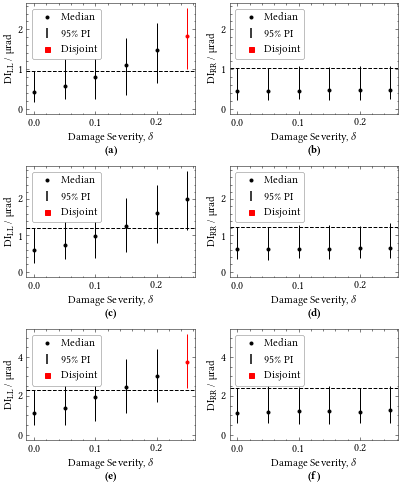

In [12]:
if MODEL == "LB":
    fig = ajf_utils.plot_pi(emd_samp_df.reset_index(), DAM_LOCS)
    ajf_plts.save_fig(fig, "figHighTrafficPIPlotsSamp.pdf")
elif MODEL == "GH":
    fig = ajf_utils.plot_pi(emd_samp_df.reset_index(), DAM_LOCS)
    ajf_plts.save_fig(fig, "fig-GH-HighTrafficPIPlotsSamp.pdf")

# Table of stats tests

### Sampled baseline

In [35]:
tab = ajf_utils.format_pred_int_table(emd_samp_df, DAM_LOCS)
with open("./output/tabHighTrafficPIsSamp.tex", "w") as f:
    f.write(tab)
print(tab)

\begin{tabular}{lcccccc}

    \toprule
    {    } & \multicolumn{3}{c}{$\DI{LL}$ (\unit{\micro\radian})} & \multicolumn{3}{c}{$\DI{RR}$ (\unit{\micro\radian})}\\
    \cmidrule(lr){2-4} \cmidrule(lr){5-7}
    $\delta$ & All &  5-axle & 6-axle &  All & 5-axle &  6-axle\\
    \midrule
    0.00 & (0.297, 1.48) & (0.475, 1.83) & (0.761, 2.94) & (0.31, 1.52) & (0.483, 1.81) & (0.667, 3.41)\\
0.02 & (0.497, 2.43) & (0.712, 2.93) & (0.98, 4.92) & (0.301, 1.9) & (0.587, 2.29) & (0.711, 4.0)\\
0.04 & (1.35, 3.43) & (1.65, 4.16) & (2.75, 6.62) & (0.437, 2.33) & (0.717, 2.96) & (1.09, 4.71)\\
0.06 & \bfseries(2.36, 4.44) & \bfseries(2.89, 5.44) & \bfseries(4.76, 8.68) & (0.76, 2.77) & (1.07, 3.44) & (1.93, 5.57)\\
0.08 & \bfseries(3.41, 5.52) & \bfseries(4.14, 6.81) & \bfseries(6.71, 10.8) & (1.17, 3.23) & (1.57, 4.0) & (2.69, 6.58)\\
0.10 & \bfseries(4.53, 6.67) & \bfseries(5.45, 8.11) & \bfseries(8.84, 12.9) & \bfseries(1.64, 3.68) & \bfseries(2.14, 4.65) & \bfseries(3.62, 7.62)\\
0.12 & \bfseri